In [2]:
## plot within the notebook
%matplotlib inline
import warnings
import numpy as np
## No annoying warnings
warnings.filterwarnings('ignore')

In [3]:
from astrobject.utils.plot.skybins import SurveyFieldBins
ztf_fields = np.genfromtxt('data/ZTF_Fields.txt', comments='%')
bins = SurveyFieldBins(ra=ztf_fields[:,1], dec=ztf_fields[:,2])
# Fields are defined by their midpoints
# Default width and height are set to 7 degrees for now
# There is more field overlap the closer you get to the poles

In [7]:
# Make a mock survey plan (by no means realistic, just trying to capture the effect of
# moving the observed part of the sky along according to the seasons)
import simsurvey.cadence as simul
obs_days = np.arange(58000, 58181, 1)

dec_range = [-20, 60]
ra_range = [0, 90]
ra_shift = 360. / 365.25

t_obs = 60.
t_night = 8. * 3600

obs = {'time': [], 'field': [], 'band': [], 'skynoise': []}
for d in obs_days:
    # Find fields that have their center within dec_range and in ra_range shifted by ra_shift for each day
    field_idx = np.where((bins.ra > ra_range[0] + ra_shift * (d - obs_days[0])) &
                         (bins.ra < ra_range[1] + ra_shift * (d - obs_days[0])) &
                         (bins.dec > dec_range[0]) & (bins.dec < dec_range[1]))[0]
    
    # Sort first by ra then by dec
    field_idx = field_idx[np.argsort(bins.ra[field_idx])]
    field_idx = field_idx[np.argsort(bins.dec[field_idx])]

    for k, t in enumerate(np.arange(0, t_night, t_obs)):
        obs['time'].append(d + t / 86400.)
        obs['field'].append(field_idx[k % len(field_idx)])
        obs['band'].append(['desr', 'desg'][(k / len(field_idx)) % 2])
        obs['skynoise'].append(400.) # Tuned to give 1% flux error at R=18 in combination with gain=0.25 
        
plan = simul.SurveyPlan(time=obs['time'], band=obs['band'], obs_field=obs['field'],
                        skynoise=obs['skynoise'],
                        fields=dict(ra=ztf_fields[:,1], dec=ztf_fields[:,2]))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x1092b9310>,
 'cbar': <matplotlib.colorbar.ColorbarBase instance at 0x10ab6dd40>,
 'collection': <matplotlib.collections.PolyCollection at 0x10ab7a350>,
 'figure': <matplotlib.figure.Figure at 0x1092acc10>}

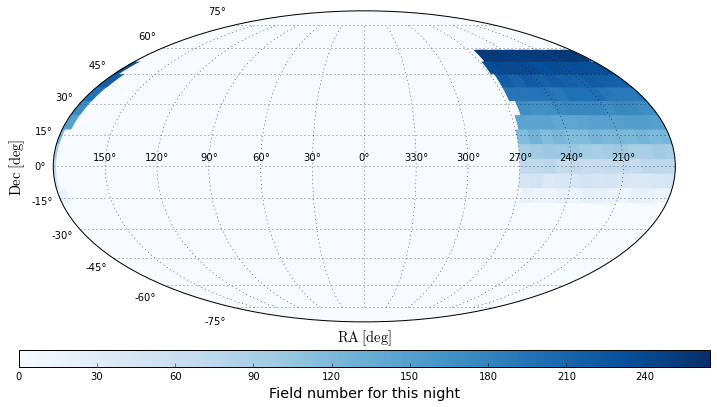

In [8]:
# Example of selected fields (last of the nights in the mock survey)
# The fields are number by the order in which they are observed.
vals = np.zeros(bins.nbins)
for k,l in enumerate(field_idx):
    vals[l] = k
    
bins.imshow(vals, cblabel="Field number for this night")

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x10b13be90>,
 'cbar': <matplotlib.colorbar.ColorbarBase instance at 0x10b154f38>,
 'collection': <matplotlib.collections.PolyCollection at 0x10b3be710>,
 'figure': <matplotlib.figure.Figure at 0x1092aca10>}

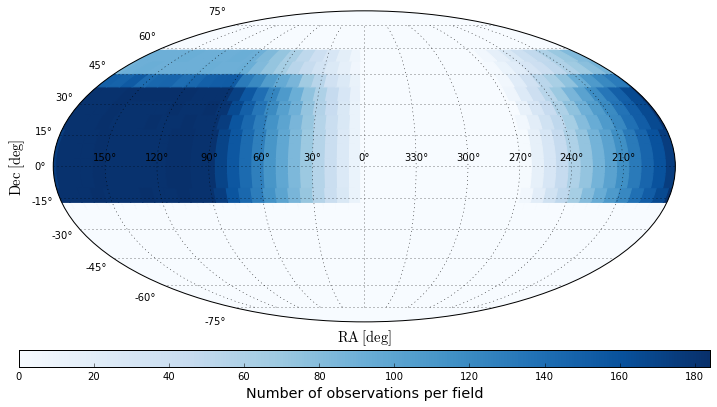

In [9]:
# Number of pointings per field
vals, _ = np.histogram(obs['field'], bins=range(bins.nbins + 1))
bins.imshow(vals, cblabel="Number of observations per field")

In [10]:
tr = simul.get_sn_generator([0.01,0.1], ratekind="basic", 
                            mjd_range=[obs_days[0] - 60, obs_days[-1] + 25])
# ratekind is the rate of the transient: basiclow = 1e3 
# -> comoving volumetric rate at each redshift in units of yr^-1 Mpc^-3.
# type_ is the type of transient. 
# This will parse the ratekind+type_ do get the good rate function

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x10cec9fd0>,
 'cbar': <matplotlib.colorbar.ColorbarBase instance at 0x10b1b6290>,
 'collection': <matplotlib.collections.PolyCollection at 0x10d914cd0>,
 'figure': <matplotlib.figure.Figure at 0x1092ac990>}

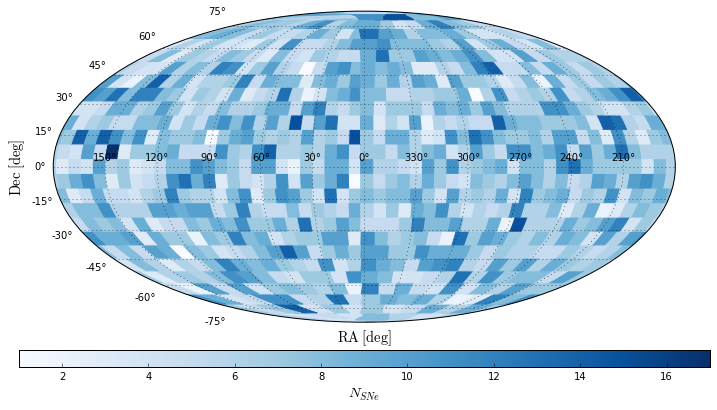

In [11]:
tr.hist_skycoverage(bins=bins)
# Since the fields can overlap, some SNe will be counted twice
# Overlapping fields partly obscure previously drawn 
# Some distortions when drawing fields near the poles (to be fixed later)

SNe observed: 1543 out of 6104


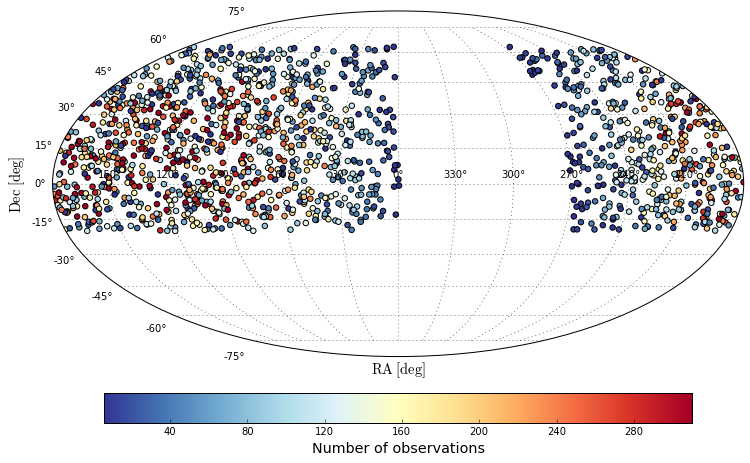

In [12]:
# SimulSurvey class collects all required components, Transient generator, survey plan and instruments
instprop = {"desg":{"gain":0.25,"zp":30,"zpsys":'ab'},
            "desr":{"gain":0.25,"zp":30,"zpsys":'ab'}}

survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)

# Generate the lightcurves. This first determines the dates on which each transient was observed
# to keep the number of lightcurve points that are calculated to a minimum
lcs = survey.get_lightcurves()
n_obs = np.array([len(a) for a in survey.plan.observed])
survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of observations", mask=(n_obs > 0))
print 'SNe observed: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

In [10]:
lcs[10:20]

[<Table masked=False length=248>
      time       band        flux         fluxerr      zp   zpsys  
    float64    string32    float64        float64    int64 string16
 ------------- -------- -------------- ------------- ----- --------
 58044.0131944     desr  188.519180916         400.0    30       ab
 58044.0236111     desr -226.117669999         400.0    30       ab
 58044.1979167     desg  27.8761170721         400.0    30       ab
 58044.2083333     desg -395.641136481         400.0    30       ab
 58045.0166667     desr -767.136059267 400.000281795    30       ab
   58045.01875     desr  219.478547038  400.00030252    30       ab
 58045.2006944     desg  1268.16811688 400.001235289    30       ab
 58045.2027778     desg -960.738427391 400.001255018    30       ab
 58046.0138889     desr -280.036079263 400.061524618    30       ab
 58046.0208333     desr  168.773530276 400.062311684    30       ab
           ...      ...            ...           ...   ...      ...
 58104.0159722 

In [20]:
# example lightcurve
lcs[7]

time,band,flux,fluxerr,zp,zpsys
float64,str4,float64,float64,int64,str2
58087.0326389,desr,29087.9666122,524.539988958,30,ab
58087.2173611,desg,16953.1275658,480.497847657,30,ab
58088.0305556,desr,28619.6099889,521.360622163,30,ab
58088.2145833,desg,16082.6499911,473.134639206,30,ab
58089.0333333,desr,26061.6552913,518.458580647,30,ab
58089.2152778,desg,14844.6372409,466.382880312,30,ab
58090.0333333,desr,25858.3240682,515.902588056,30,ab
58090.2180556,desg,12750.0782019,460.375869105,30,ab
58091.025,desr,25477.4276857,513.679916199,30,ab


In [21]:
# Its parameters
lcs[7].meta

{'c': 0.044231966308408782,
 'mwebv': 0.039596162736415863,
 't0': 58072.656021863826,
 'x0': 0.00084363537599458217,
 'x1': -1.0758906552356109,
 'z': 0.07068452887788544}

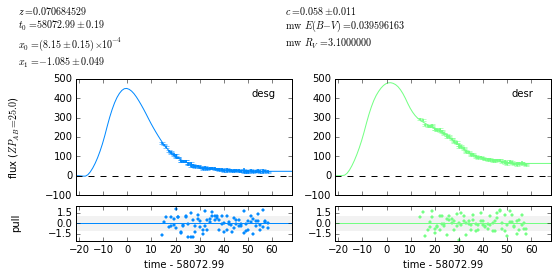

In [27]:
# Example lightcurve fit
lc = lcs[7]

import sncosmo
survey.generator.model.set(z=lc.meta['z'],mwebv=lc.meta['mwebv'])
res, fitted_model = sncosmo.fit_lc(lc, survey.generator.model, ['t0', 'x0', 'x1', 'c'])

_ = sncosmo.plot_lc(lc, model=fitted_model, errors=res.errors)

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x119900e10>,
 'cbar': <matplotlib.colorbar.Colorbar instance at 0x119905ab8>,
 'figure': <matplotlib.figure.Figure at 0x119900190>,
 'plot': <matplotlib.collections.PathCollection at 0x119544950>}

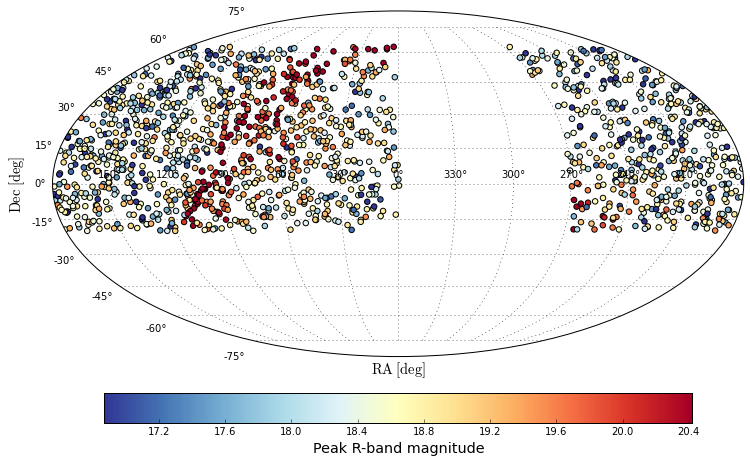

In [28]:
# MW E(B-V) is now automatically included in the lc model,
# so MW can be seen in magnitudes
peak_mag = survey.generator.get_bandmag(band='bessellr', magsys='vega', t=0) # t is time relative to t0
survey.generator.show_skycoverage(cscale=peak_mag, cblabel="Peak R-band magnitude", mask=(n_obs > 0))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x119ad5750>,
 'cbar': <matplotlib.colorbar.Colorbar instance at 0x119469a28>,
 'figure': <matplotlib.figure.Figure at 0x119f6fd50>,
 'plot': <matplotlib.collections.PathCollection at 0x119458c50>}

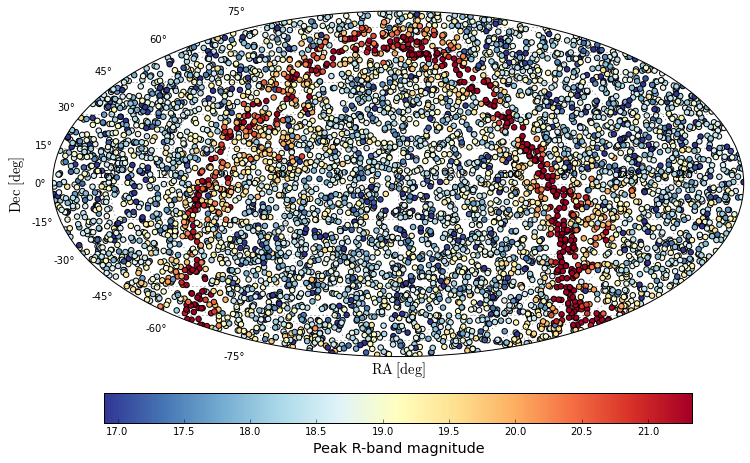

In [29]:
# It's more obvious when using the whole sample
survey.generator.show_skycoverage(cscale=peak_mag, cblabel="Peak R-band magnitude")